In [1]:
import os
import math
import random
import time
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Sampler, IterableDataset

In [2]:
from transformer import PositionalEncoding

In [3]:
MAX_LENGTH = 640
DATA_PATH = "./data/test-00000-of-00001.txt"
BATCH_SIZE = 32
device = "cuda:3"

In [4]:
class GPT2LikeModel(nn.Module):
    def __init__(self, vocab_size: int, d_model: int = 1024, nhead: int = 8, max_length: int = MAX_LENGTH):
        super().__init__()
        self.vocab_size = vocab_size

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len=max_length)
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=1)
        self.output_linear = nn.Linear(d_model, vocab_size)

    def forward(self, x: torch.Tensor, attn_mask: torch.Tensor = None) -> torch.Tensor:
        # x: [batch, seq_len]
        x = self.embedding(x)             # [batch, seq_len, d_model]
        x = self.positional_encoding(x)
        x = x.transpose(0, 1)             # [seq_len, batch, d_model]
        # In this mock setup we use x as both tgt and memory.
        out = self.decoder(tgt=x, memory=x, tgt_mask=attn_mask)
        out = out.transpose(0, 1)         # [batch, seq_len, d_model]
        logits = self.output_linear(out)  # [batch, seq_len, vocab_size]
        return logits

In [5]:
def run_epoch(loader: DataLoader, model: nn.Module, device: torch.device) -> np.ndarray:
    times = []
    model.eval()
    with torch.no_grad():
        for batch in loader:
            
            if isinstance(batch, tuple):
                input_ids, attn_mask = batch
                attn_mask = attn_mask.to(device)
            else:
                input_ids = batch
                attn_mask = None
            input_ids = input_ids.to(device)

            torch.cuda.synchronize()
            start_event = torch.cuda.Event(enable_timing=True)
            end_event = torch.cuda.Event(enable_timing=True)
            start_event.record()
            _ = model(input_ids, attn_mask)
            end_event.record()
            torch.cuda.synchronize()
            elapsed = start_event.elapsed_time(end_event)  # milliseconds
            times.append(elapsed)
    return np.array(times)


In [6]:
from transformers import AutoTokenizer


def get_tokenizer():
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({"pad_token": "[PAD]"})
    return tokenizer

tokenizer = get_tokenizer()

/home/byzovti/.conda/envs/effdl2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
import numpy as np

stats = {}

def compute_stats(times: np.ndarray):
    return {
        "min (ms)": float(np.min(times)),
        "max (ms)": float(np.max(times)),
        "mean (ms)": float(np.mean(times)),
        "median (ms)": float(np.median(times)),
    }

In [8]:
def warmup(model: GPT2LikeModel, device: torch.device):
    model.eval()
    dummy_input = torch.randint(0, model.vocab_size, (BATCH_SIZE, MAX_LENGTH), device=device)
    with torch.no_grad():
        for _ in range(150):
            _ = model(dummy_input)
    torch.cuda.synchronize()

In [9]:
model = GPT2LikeModel(vocab_size=tokenizer.vocab_size, d_model=1024, nhead=8, max_length=MAX_LENGTH).to(device)
model.eval()

GPT2LikeModel(
  (embedding): Embedding(30522, 1024)
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0): TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (linear1): Linear(in_features=1024, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=1024, bias=True)
        (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (norm3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1,

In [10]:
warmup(model, device)

In [11]:
from dataset import BrainDataset

brain_dataset = BrainDataset(DATA_PATH, tokenizer, max_length=MAX_LENGTH)
loader_brain = DataLoader(brain_dataset, batch_size=BATCH_SIZE, shuffle=True)

stats["brain"] = compute_stats(run_epoch(loader_brain, model, device))

Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors


In [12]:
from dataset import BigBrainDataset, manual_collate_fn


big_brain_dataset = BigBrainDataset(DATA_PATH, tokenizer)
loader_big_brain = DataLoader(big_brain_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=lambda b: manual_collate_fn(b, max_length=None))

stats["big_brain"] = compute_stats(run_epoch(loader_big_brain, model, device))

stats["big_brain"]

{'min (ms)': 1.814527988433838,
 'max (ms)': 3.274751901626587,
 'mean (ms)': 2.2994872960415513,
 'median (ms)': 2.3345279693603516}

In [13]:
from dataset import UltraBigBrainBatchSampler, UltraBigBrainDataset, manual_collate_fn


ultra_big_brain_dataset = UltraBigBrainDataset(
    DATA_PATH,
    tokenizer
)

for k in (1, 5, 10, 20, 50):

    batch_sampler = UltraBigBrainBatchSampler(ultra_big_brain_dataset, batch_size=BATCH_SIZE, k=20)

    ultra_big_brain_loader = DataLoader(
        ultra_big_brain_dataset,
        batch_sampler=batch_sampler,
        collate_fn=lambda b: manual_collate_fn(b, max_length=None)
    )
    print(f"k is {k}")
    stats[f"ultra_big_brain_{k}"] = compute_stats(run_epoch(ultra_big_brain_loader, model, device))
    print(stats[f"ultra_big_brain_{k}"])
    print("-------------")

    


k is 1
{'min (ms)': 1.235967993736267, 'max (ms)': 7.973728179931641, 'mean (ms)': 1.9439237996683283, 'median (ms)': 1.9061920046806335}
-------------
k is 5
{'min (ms)': 1.148959994316101, 'max (ms)': 2.6439359188079834, 'mean (ms)': 1.7651138045206791, 'median (ms)': 1.7778559923171997}
-------------
k is 10
{'min (ms)': 1.1192320585250854, 'max (ms)': 2.8537280559539795, 'mean (ms)': 1.746714570764768, 'median (ms)': 1.7561919689178467}
-------------
k is 20
{'min (ms)': 1.1241600513458252, 'max (ms)': 2.865151882171631, 'mean (ms)': 1.6573521383738115, 'median (ms)': 1.6517120003700256}
-------------
k is 50
{'min (ms)': 1.0833920240402222, 'max (ms)': 2.9317119121551514, 'mean (ms)': 1.6333371840539526, 'median (ms)': 1.572975993156433}
-------------


### Сделаем выводы



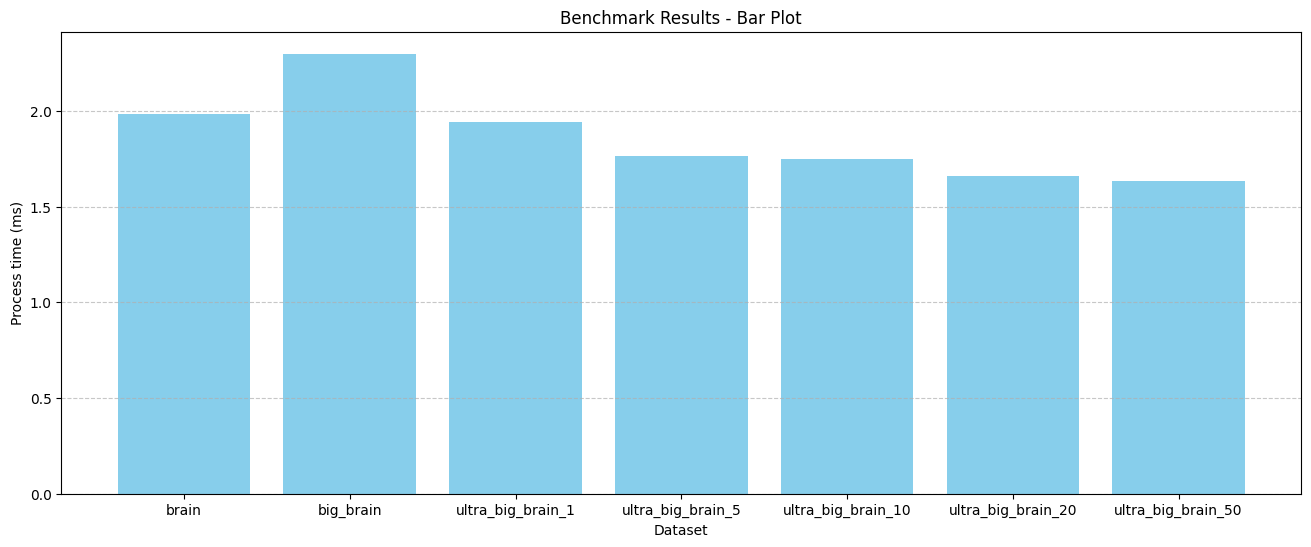

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


df = pd.DataFrame(list(stats.items()), columns=['Dataset', 'Value'])
plt.figure(figsize=(16, 6))
plt.bar(df['Dataset'], [experiment['mean (ms)'] for experiment in df['Value']], color='skyblue')
plt.xlabel('Dataset')
plt.ylabel('Process time (ms)')
plt.title('Benchmark Results - Bar Plot')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# plt.figure(figsize=(8, 6))
# plt.hist(df['Value'], bins=5, color='salmon', edgecolor='black')
# plt.xlabel('Time (ms)')
# plt.ylabel('Frequency')
# plt.title('Benchmark Results - Histogram')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()

Замечу, что, не смотря на победу во времени процессинга brain над big_brain, подргузка самого датасета и испольнение программы целиком в разы (3-4) дольше, чем в остальных подходах.